# Bag of tricks for efficient text classification

### Import the necessary stuff

In [26]:
import numpy as np
import tensorflow as tf
import matplotlib.image as img
import matplotlib.pyplot as plt
from collections import defaultdict

# inline matplotlib
%matplotlib inline

### Model Architecture

#### Probability distribution over predefined classes

$$
\\- \frac{1}{N}\sum_{n=1}^{N} y_n \log(f(BAx_n))
\\
where\\
x_n = normalized \hspace{0.075cm} bag \hspace{0.075cm} of \hspace{0.075cm} features \hspace{0.075cm} of \hspace{0.075cm} the \hspace{0.075cm} n^{th} \hspace{0.075cm} document\\
y_n = the \hspace{0.075cm} label\\
A, B = weight \hspace{0.075cm} matrices\\
$$

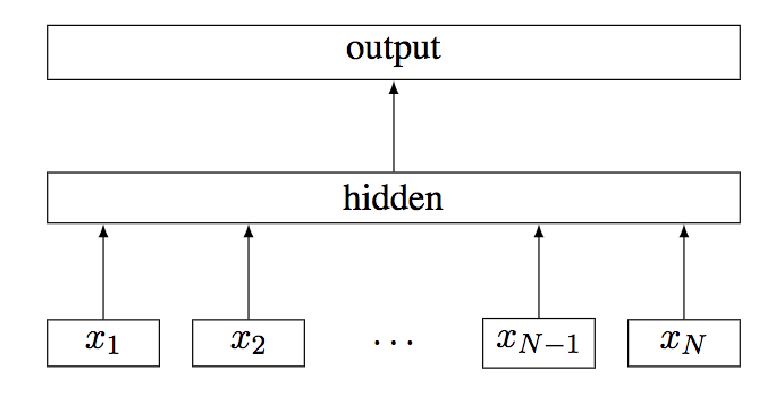

In [27]:
i = img.imread('1.png')

# remove all unecessary stuff and display the image
plt.rcParams['figure.figsize'] = (13, 13)
plt.axis('off')
plt.imshow(i)

In [30]:
# init an empty parameter set with a defaultdict
parms = defaultdict(dict)

parms['label_size'] = 10
parms['batch_size'] = 10
parms['vocab_size'] = 20
parms['learn_rate'] = 0.1

# Problem Statement

#### Some metadata about the dataset
NIPS is a machine learning conference focussed on diverse machine learning topics ranging from neural networks, deep learning etc. The dataset that would be used for the experiment is a time series collection of scholarly data that includes mostly textual data. The papers range from the timeline `1987` - `2017`. 

#### The research question
Can we use `fastText` to build a word embedding model that would cluster scholarly papers on the basis of topic and is there a significant computational advantange of using `fastText` over a normal `word2vec` model.

#### what is word2vec ?
Vectorization in linguistics and natural language processing is a process where words/text are mapped into vectors so that there is a numerical model of the text build for the machine to easily understand the nature of the text. `word2vec` is a vectorization technique that represents the target words of a corpus into a neural network where the hidden layer encodes the word representation. `word2vec` conceptually works with two types of implementations:
- `skip-gram`:
       A neural network representation technique where the input is the target word and the outputs are the words surrounding the target words. The input and the outputs are generally based out of the same dimension. The hidden layer for the neural network is equal to the word embedding size. The activation function is applied on each element so that it could each element of the output vector describe how a specific word will appear in the context. This model is efficient for understanding relationship between two vectors
- `CBOW`:
   A representation
   
#### what is fastText ?
    

# Baseline Deep learning models

# Train the fastText model

In [3]:
# train

# Test the fastText model

In [29]:
# test